# Caso WalMart: Sales in Stormy Weather
por: Diego López, Lillian Lecca y Hugo Castillo

### Basado en el concurso de Kaggle [WalMart Recruiting II](https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather)

Versión 1.0 para el curso de PEA Big Data y Business Analytics 2016


## Sobre el caso

Walmart opera mas de 10,000 tiendas en 30 países, gestionando sus inventorios en ambientes y culturas variadas. Climas extremos, como huracanes, ventiscas e inundaciones puden tener un alto impacto en las ventas en las tiendas y en el stock de los productos

Para esta competencia, Walmart invita a los participantes a predecir con precisión la venta de 111 productos sensibles a cambios climáticos alrededor de 45 ciudades donde se ubican distintas tiendas.

## Sobre la data

Se cuenta con la información de las unidades vendidas en una tienda dada para una fecha específica dentro de los archivos test y train. Adicionalmente se encuentra con un archivo del estado climatológico de las tiendas el cual se conecta a los archivos test y train a traves del archivo key.csv

No se cuentan con los nombres de los productos, así como con categorización alguna para poder realizar asociaciones

A continuación, se muestra como va la evolución de las ventas para algunas tiendas y productos

In [1]:
# Leemos todos los CSV del proyecto
import pandas as pd
import numpy as np
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
keys = pd.read_csv("key.csv")
weather = pd.read_csv("weather.csv")

C:\Users\Diego\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Diego\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


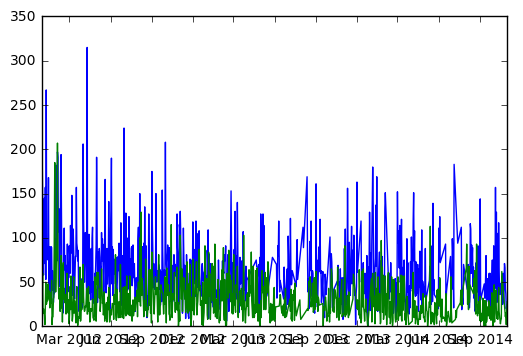

In [2]:
# El siguiente gráfico toma dos productos y muestra su evolución de demanda en el tiempo
%matplotlib inline
import matplotlib.pyplot as plt
graph = train[(train.store_nbr == 2) & (train.item_nbr == 5)]
graph['date'] = pd.to_datetime(graph['date'])
plt.plot(graph.date,graph.units)
graph = train[(train.store_nbr == 1) & (train.item_nbr == 9)]
graph['date'] = pd.to_datetime(graph['date'])
plt.plot(graph.date,graph.units)

## Preparación de Datos

In [3]:
# cruzamos los csv las tiendas con los climas
clima_tienda = weather.merge(keys,how='left')

In [4]:
# Filtramos solo fechas y estaciones que tengan con clima extremo para optimizar cruces y comparaciones

# 1. Arreglamos el campo snowfall que contiene los centimetros de lluvia o nieve ya que hay campos con valor
# M y T los cuales seran tomados como NaN
clima_tienda.snowfall = pd.to_numeric(clima_tienda.snowfall, errors='coerce')
# Criterio para filtrar lluvia: RA
criterio1 = ((clima_tienda['codesum'].str.contains("RA")) & (clima_tienda['snowfall'] >= 1))
# Criterio para filtrar lluvia: SN
criterio2 = ((clima_tienda['codesum'].str.contains("SN")) & (clima_tienda['snowfall'] >= 2))
# Juntamos lod dos criterios
tienda_fecha_ce = clima_tienda[criterio1 | criterio2]

# hago un df solo de dos columnas (tienda y fecha) eliminando duplicados
tienda_fecha_ce = tienda_fecha_ce[['store_nbr','date']].drop_duplicates()

In [5]:
from datetime import timedelta
from datetime import datetime

# Crearemos un DF por cada dia antes o despues a analizar a la fecha del dia extremo
# Cada DF es una copia de tienda_fecha_ce al que se le ira agregando x dias a su fecha

# Primero convertimos la columna a tipo date para hacer operaciones de tiempo
tienda_fecha_ce['date'] = pd.to_datetime(tienda_fecha_ce['date'])

# Creamos una copia y aumentamos un dia
tienda_fecha_ce_plus1 = tienda_fecha_ce.copy()
tienda_fecha_ce_plus1['date'] = tienda_fecha_ce_plus1['date'] + timedelta(days=1)
tienda_fecha_ce_plus1['clima_extr_plus1'] = 1 #flag de ayuda

# Creamos una copia y quitamos un dia
tienda_fecha_ce_minus1 = tienda_fecha_ce.copy()
tienda_fecha_ce_minus1['date'] = tienda_fecha_ce_minus1['date'] + timedelta(days=-1)
tienda_fecha_ce_minus1['clima_extr_minus1'] = 1 #flag de ayuda

tienda_fecha_ce['clima_extr'] = 1 #flag de ayuda

In [6]:
# Creamos una copia del train y transformamos su columna date para operaciones posteriores
trainv2 = train.copy()
trainv2['date'] = pd.to_datetime(trainv2['date'])

# utilizamos los df previamente calculados y los cruzamos con train, el flag de ayuda me indicara si para ese dia y fecha hubo clima extremo
trainv2 = pd.merge(trainv2,tienda_fecha_ce,how='left', on=['date', 'store_nbr'])
trainv2 = pd.merge(trainv2,tienda_fecha_ce_plus1,how='left', on=['date', 'store_nbr'])
trainv2 = pd.merge(trainv2,tienda_fecha_ce_minus1,how='left', on=['date', 'store_nbr'])
trainv2 = trainv2.fillna(0)

# Ahora podremos observar los campos clima_extr, clima_extr_plus1, clima_extr_minus1
# Cada uno representa un flag si esa fecha hubo clima extremo
trainv2.head()

,date,store_nbr,item_nbr,units,clima_extr,clima_extr_plus1,clima_extr_minus1
0,2012-01-01,1,1,0,0.0,0.0,0.0
1,2012-01-01,1,2,0,0.0,0.0,0.0
2,2012-01-01,1,3,0,0.0,0.0,0.0
3,2012-01-01,1,4,0,0.0,0.0,0.0
4,2012-01-01,1,5,0,0.0,0.0,0.0


In [7]:
# Agregamos algunos campos que pueden ser útiles
from datetime import date

# eliminamos items 0
trainv2 = trainv2[trainv2.units > 0]

# separando la fecha
trainv2['year'] = pd.DatetimeIndex(trainv2['date']).year
trainv2['month'] = pd.DatetimeIndex(trainv2['date']).month
trainv2['day'] = pd.DatetimeIndex(trainv2['date']).day
# dia de la semana
trainv2['weekday'] = pd.DatetimeIndex(trainv2['date']).dayofweek
# si es fin de semana
trainv2['is_weekend'] = 0
trainv2.loc[trainv2.weekday > 4 , 'is_weekend'] = 1

# blackfridays
blackfridays = pd.to_datetime(pd.Series(['2012-11-23','2013-11-29','2014-11-28','2015-11-28']))
trainv2['blackfriday'] = 0
for i,bf in blackfridays.iteritems():
    trainv2.loc[trainv2.date == bf , 'blackfriday'] = 1


# feriados
feriados = pd.to_datetime(pd.Series(['2013-01-01','2013-01-18','2013-02-15','2013-04-15','2013-05-08','2013-05-30','2013-06-19','2013-07-04','2013-09-05','2013-10-10','2013-11-11','2013-11-24','2013-11-25','2013-12-26','2014-01-01','2014-01-18','2014-02-15','2014-04-15','2014-05-08','2014-05-30','2014-06-19','2014-07-04','2014-09-05','2014-10-10','2014-11-11','2014-11-24','2014-11-25','2014-12-26','2012-01-01','2012-01-18','2012-02-15','2012-04-15','2012-05-08','2012-05-30','2012-06-19','2012-07-04','2012-09-05','2012-10-10','2012-11-11','2012-11-24','2012-11-25','2012-12-26']))
trainv2['holiday'] = 0
for i,bf in blackfridays.iteritems():
    trainv2.loc[trainv2.date == bf , 'holiday'] = 1

In [8]:
trainv2.head()

,date,store_nbr,item_nbr,units,clima_extr,clima_extr_plus1,clima_extr_minus1,year,month,day,weekday,is_weekend,blackfriday,holiday
8,2012-01-01,1,9,29,0.0,0.0,0.0,2012,1,1,6,1,0,0
27,2012-01-01,1,28,2,0.0,0.0,0.0,2012,1,1,6,1,0,0
50,2012-01-01,1,51,1,0.0,0.0,0.0,2012,1,1,6,1,0,0
115,2012-01-01,2,5,191,0.0,0.0,0.0,2012,1,1,6,1,0,0
154,2012-01-01,2,44,215,0.0,0.0,0.0,2012,1,1,6,1,0,0


In [14]:
# Transformamos variables a categoricas
trainv2['store_nbr'] = trainv2['store_nbr'].astype('category')
trainv2['item_nbr'] = trainv2['item_nbr'].astype('category')
trainv2['weekday'] = trainv2['weekday'].astype('category')

# Utilizaremos Regresión linear, SGD Regressor y Arbol de Decision para realizar los cálculos y cross val score para determinar su promedio de error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import cross_val_score
from sklearn import metrics

fields = ['store_nbr','item_nbr','clima_extr','weekday','is_weekend','month','day','blackfriday','holiday'];
y = np.asarray(trainv2['units'],dtype='i')
res_reglin,res_sgd,res_dt = [],[],[]

clf1 = LinearRegression()
clf2 = SGDRegressor(n_iter=10)
clf4 = DecisionTreeRegressor(random_state=1)

for i in range(10,13):
    res_reglin = np.append(res_reglin,cross_val_score(clf1, trainv2[fields], y, cv=i, scoring='neg_mean_absolute_error'))
    res_sgd = np.append(res_sgd,cross_val_score(clf2, trainv2[fields], y, cv=i, scoring='neg_mean_absolute_error'))
    res_dt = np.append(res_dt,cross_val_score(clf4, trainv2[fields], y, cv=i, scoring='neg_mean_absolute_error'))

print(pd.Series(res_reglin).describe())
print(pd.Series(res_sgd).describe())
print(pd.Series(res_dt).describe())

# Al ver los resultados concluimos que Decision Tree es lo más optimo (menor error promedio y menor desviación)

count    33.000000
mean    -30.808586
std       2.793208
min     -35.959068
25%     -32.061997
50%     -31.357241
75%     -29.284456
max     -24.939831
dtype: float64
count    3.300000e+01
mean    -1.223141e+08
std      1.966491e+08
min     -7.606340e+08
25%     -9.596414e+07
50%     -4.490651e+07
75%     -1.659347e+07
max     -2.278606e+06
dtype: float64
count    33.000000
mean    -16.903352
std       1.163888
min     -19.017489
25%     -17.606309
50%     -16.851080
75%     -16.017422
max     -14.751693
dtype: float64


In [36]:
# Dibujando decision tree para conocer importancia de variables
from sklearn.tree import export_graphviz

clf4.fit(trainv2[fields], y)
export_graphviz(clf4, out_file='tree_walmart.dot', feature_names=fields, max_depth = 5)

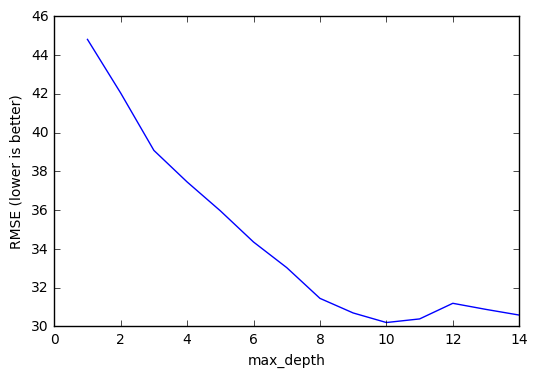

In [25]:
# Optimizando profundidad para Random Forest
max_depth_range = range(1, 15)
RMSE_scores = []

for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, trainv2[fields], y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

# Graficando
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

#la respuesta es 10

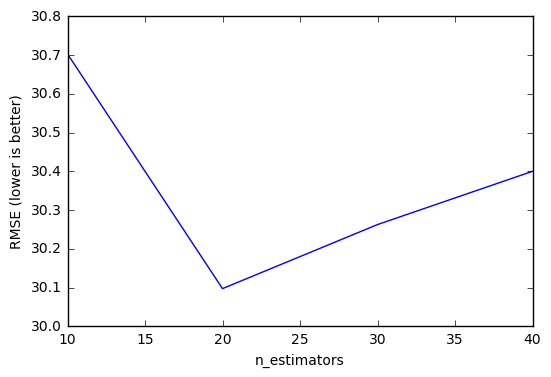

In [27]:
# Optimizando estimadores
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
RMSE_scores = []

estimator_range = range(10, 50, 10)

for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    MSE_scores = cross_val_score(rfreg, trainv2[fields], y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

# plot n_estimators (x-axis) versus RMSE (y-axis)
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

# la respuesta es 20 estimadores

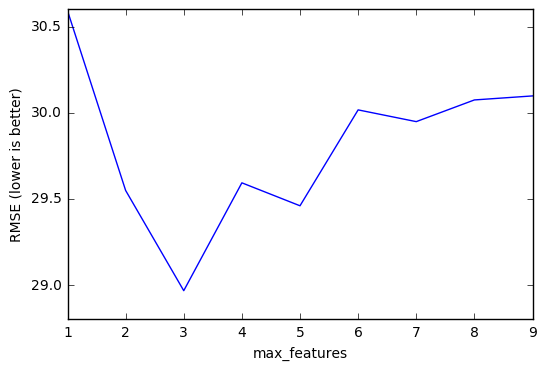

In [31]:
# Optimizando Features

feature_range = range(1, len(fields) +1)

RMSE_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=20, max_features=feature, random_state=1, n_jobs=-1)
    MSE_scores = cross_val_score(rfreg, trainv2[fields], y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
    
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')

# la respuesta es 3 features

In [15]:
# Adaptando test a las nuevas variables
testv2 = test.copy()
testv2['date'] = pd.to_datetime(testv2['date'])

testv2 = pd.merge(testv2,tienda_fecha_ce,how='left', on=['date', 'store_nbr'])
testv2 = pd.merge(testv2,tienda_fecha_ce_plus1,how='left', on=['date', 'store_nbr'])
testv2 = pd.merge(testv2,tienda_fecha_ce_minus1,how='left', on=['date', 'store_nbr'])
testv2 = testv2.fillna(0)

from datetime import date

# separando la fecha
testv2['year'] = pd.DatetimeIndex(testv2['date']).year
testv2['month'] = pd.DatetimeIndex(testv2['date']).month
testv2['day'] = pd.DatetimeIndex(testv2['date']).day
# dia de la semana
testv2['weekday'] = pd.DatetimeIndex(testv2['date']).dayofweek
# si es fin de semana
testv2['is_weekend'] = 0
testv2.loc[testv2.weekday > 4 , 'is_weekend'] = 1

# blackfridays
testv2['blackfriday'] = 0
for i,bf in blackfridays.iteritems():
    testv2.loc[testv2.date == bf , 'blackfriday'] = 1

# feriados
testv2['holiday'] = 0
for i,bf in blackfridays.iteritems():
    testv2.loc[testv2.date == bf , 'holiday'] = 1

# categorizando
testv2['store_nbr'] = testv2['store_nbr'].astype('category')
testv2['item_nbr'] = testv2['item_nbr'].astype('category')
testv2['weekday'] = testv2['weekday'].astype('category')

In [16]:
# Aplicamos nuestro random forest con los parametros tuneados
treereg = RandomForestRegressor(n_estimators=20, max_features=3, max_depth = 10, random_state=1)
treereg.fit(trainv2[fields],y)

# Predecimos
Y_pred = treereg.predict(testv2[fields])
#testv2["period"] = "{}_{}_{}".format()testv2["store_nbr"],testv2["item_nbr"],testv2["date"]

# Exportamos y enviamos a Kaggle
submission = pd.DataFrame({
        "store": testv2.store_nbr.values,
        "item_nbr": testv2.item_nbr.values,
        "date": testv2.date.values,
        "item": Y_pred
    }, columns = ["store","item_nbr","date","item"])
submission.to_csv('prediction1.csv', index=False)

# Conclusiones

- Al ser predicción de demanda, se usan modelos de regresión
- Fue necesario primero una limpieza de la data, quitar todos los items que tenian 0 ventas mejoró la performance y la precisión
- Gracias a experiencia en Retail se fueron agregando nuevas variables referidas a fechas especiales que muevan la demanda
- Se probaron distintos modelos de regresión siendo el árbol de decisión el de menor margen de error y desviación estándar
- Se disminuyó el margen de error del árbol de decisión al aplicar Random Forest con parámetros tuneados
- De acuerdo al primer decision tree dibujado la variable mas importante es weekday